In [1]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Toxicity classification using Gemini fine-tuned


<table align="left">

<a href="https://github.com/GoogleCloudPlatform/ai-ml-recipes/blob/main/notebooks/generative_ai/classification/toxicity_classification.ipynb">
<img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
View on GitHub
</a>
</td>
<td>
<a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/ai-ml-recipes/main/notebooks/generative_ai/classification/toxicity_classification.ipynb">
<img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
Open in Vertex AI Workbench
</a>
</td>
</table>

## Overview

This notebook shows how to classify human text toxic comments into different Responsible AI harms categories: "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"

#### **Steps**
Using Bigframes (BigQuery Dataframes),
1) It reads the [```Jigsaw Multilingual Toxic Comment Classification```](https://www.kaggle.com/competitions/jigsaw-multilingual-toxic-comment-classification/data) dataset 
2) It preprocess the dataset and split into train and test for finetuning and metrics evaluation  
3) It requests the Gemini model API to classify the text comment for the different categories (multi-label classification)  
4) It evaluates the Precision scores and F1 scores
5) It fine-tunes the Gemini model for this type of classification and evaluates the results against the test dataset again to compare the quality increase

References:
- [BigQuery DataFrames](https://cloud.google.com/python/docs/reference/bigframes/latest)

### Costs

This tutorial uses billable components of Google Cloud:

* BigQuery (compute)
* BigQuery ML

Learn about [BigQuery compute pricing](https://cloud.google.com/bigquery/pricing#analysis_pricing_models)
and [BigQuery ML pricing](https://cloud.google.com/bigquery/pricing#bqml),
and use the [Pricing Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Setup

In [ ]:
!pip install --upgrade google-cloud-bigquery google-cloud-aiplatform bigframes -q


1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

3. [Enable the BigQuery API](https://console.cloud.google.com/flows/enableapi?apiid=bigquery.googleapis.com).

4. If you are running this notebook locally, install the [Cloud SDK](https://cloud.google.com/sdk).

### Import dependencies

In [ ]:
import json
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.cloud import bigquery, storage

import bigframes.pandas as bpd
import bigframes.bigquery as bbq
from bigframes.dataframe import DataFrame
from bigframes.ml.model_selection import train_test_split
from bigframes.ml import metrics

### Set BigQuery DataFrames options

In [ ]:
PROJECT_ID = "<YOUR_PROJECT_ID>"
REGION = "US"

Before running, [create a BigQuery dataset](https://cloud.google.com/bigquery/docs/datasets) and a [BigQuery connection](https://cloud.google.com/bigquery/docs/create-cloud-resource-connection) and refer them below

In [ ]:
DATASET_ID = "<YOUR_BQ_DATASET_NAME>"
CONNECTION_ID = "<YOUR_BQ_CONNECTION_ID>"

In [ ]:
bpd.options.bigquery.project = PROJECT_ID
bpd.options.bigquery.location = REGION
bpd.options.display.progress_bar = None

## Read the dataset using BigQuery Dataframes

In [ ]:
df = bpd.read_csv("gs://dataproc-metastore-public-binaries/jigsaw/jigsaw-toxic-comment-train.csv")

In [ ]:
classification_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

## Visualize basic statistics

In [9]:
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation Why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,""" More I can't make any real suggestions on im...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,""" Congratulations from me as well, use the to...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [10]:
ids_count = df["id"].count()
print(f"Total: {ids_count}")

Total: 223549


In [ ]:
classification_counts = df[classification_columns].sum()
classification_counts

In [ ]:
def plot_percentages(classification_counts: DataFrame, total: int):
    
    percentages = (classification_counts / total) * 100

    plt.figure(figsize=(10, 5))
    plt.bar(percentages.index, percentages.values)
    plt.title('Distribution of Classifications (Percentage)')
    plt.xlabel('Classification Type')
    plt.ylabel('Percentage of Occurrences')
    plt.xticks(rotation=45)
    plt.show()

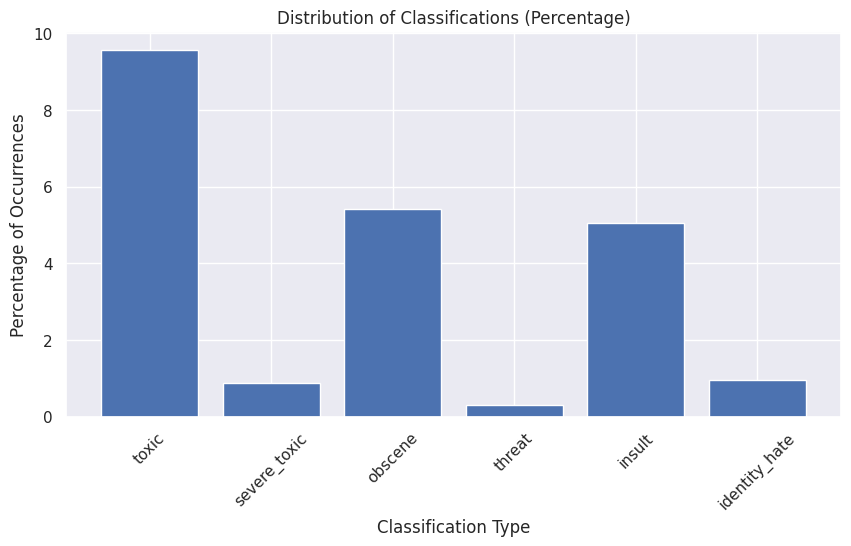

In [13]:
plot_percentages(classification_counts, ids_count)

## Preprocess dataset

Sample the data with **at least** a sample_size for each column in classification_columns  
Including a sample with rows where all classification_columns are 0   

### Balance dataset

In [ ]:
def balance_dataset(df: DataFrame, classification_columns: List, sample_size):

    sampled_dfs = []

    for col in classification_columns:
        temp_df = df[df[col] == 1].sample(sample_size)
        sampled_dfs.append(temp_df)

    all_zeroes_df = df[(df[classification_columns] == 0).all(axis=1)].sample(sample_size)
    sampled_dfs.append(all_zeroes_df)

    balanced_df = bpd.concat(sampled_dfs) # could create duplicates, dropping for simplicity
    balanced_df.drop_duplicates()
    
    return balanced_df

In [ ]:
SAMPLE_SIZE = 100

In [ ]:
balanced_data = balance_dataset(df, classification_columns, sample_size = SAMPLE_SIZE)

In [ ]:
def plot_distribution(classification_counts: DataFrame):

    plt.figure(figsize=(10, 5))
    plt.bar(classification_counts.index, classification_counts.values)
    plt.title('Distribution of Classifications')
    plt.xlabel('Classification Type')
    plt.ylabel('Number of Occurrences')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
balanced_data_counts = balanced_data[classification_columns].sum()
balanced_data_counts

In [19]:
total = balanced_data["id"].count()
print(f"Total: {total}")

Total: 700


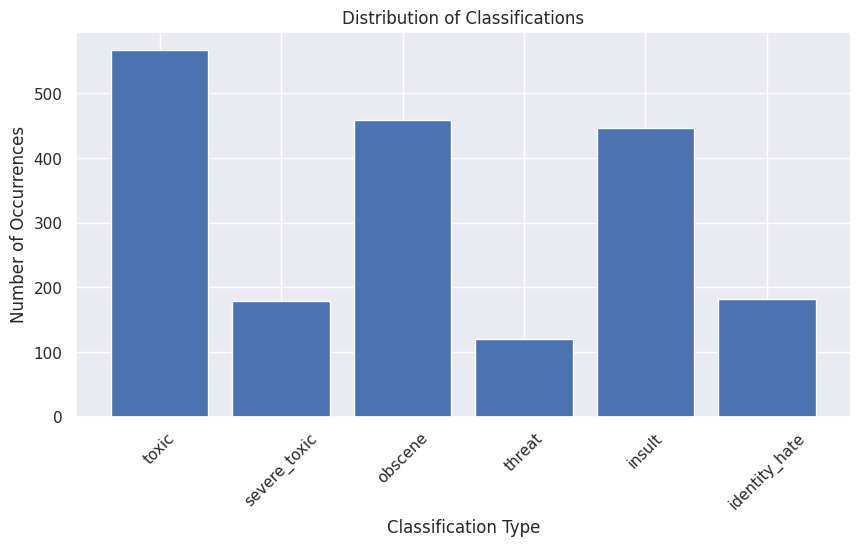

In [20]:
plot_distribution(balanced_data_counts)

### Split dataset

In [ ]:
train_df, test_df = train_test_split(balanced_data, test_size=0.2, random_state=42)

In [22]:
print("Training data sample size: ", train_df["id"].count())
print("Test data sample size: ", test_df["id"].count())

Training data sample size:  560
Test data sample size:  140


#### Persist this transformed data to BigQuery to simplify the execution graph

In [ ]:
train_df.to_gbq(destination_table=f"{PROJECT_ID}.{DATASET_ID}.toxicity_train_dataset", if_exists="replace")
test_df.to_gbq(destination_table=f"{PROJECT_ID}.{DATASET_ID}.toxicity_test_dataset", if_exists="replace")

In [ ]:
train_dataset = bpd.read_gbq(f"{PROJECT_ID}.{DATASET_ID}.toxicity_train_dataset")
test_dataset = bpd.read_gbq(f"{PROJECT_ID}.{DATASET_ID}.toxicity_test_dataset")

## Configure Gemini

In [ ]:
system_instructions = [
    """You are a Responsible AI specialist, and analysis harmful content with the objective of filtering such undesired content from the web via your analysis""",
    """You will respond only 0s or 1s in JSON format to the following fields: "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate" """
]

In [ ]:
response_schema = {
    "type": "OBJECT",
    "properties": {
        "toxic": {"type": "INTEGER"},
        "severe_toxic": {"type": "INTEGER"},
        "obscene": {"type": "INTEGER"},
        "threat": {"type": "INTEGER"},
        "insult": {"type": "INTEGER"},
        "identity_hate": {"type": "INTEGER"}
    },
    "required": ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"],
}

In [ ]:
prompt = """
Your task is to analyze comments from the web and classify if the content is related to the following classifications: "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"
Here is the comment you should analyze and generate the structured response with the classifications: 
"""

In [ ]:
def predict(prompt, model_name):

    from vertexai.generative_models import GenerativeModel, GenerationConfig, Part, Content, HarmCategory, HarmBlockThreshold
    
    model = GenerativeModel(model_name=model_name, system_instruction=system_instructions)
    
    prompt_content = Content(
        role="user",
        parts=[Part.from_text(prompt)]
    )

    response = model.generate_content(
        prompt_content,
        generation_config=GenerationConfig(
            max_output_tokens=128, temperature=0.5, response_mime_type="application/json", response_schema=response_schema
        ),
        safety_settings={
                HarmCategory.HARM_CATEGORY_UNSPECIFIED: HarmBlockThreshold.BLOCK_ONLY_HIGH
        }
    )
    
    return response.text

In [ ]:
@bpd.remote_function(
    [str, str],
    str,
    bigquery_connection=CONNECTION_ID,
    packages=["google-cloud-aiplatform"]
)
def generate_predictions(prompt: str, model_name: str) -> str:
    
    prediction = predict(prompt, model_name)
    
    return prediction

## Run predictions against the test dataset using Gemini (default)

In [ ]:
test_dataset["input_prompt"] = prompt + test_dataset["comment_text"]

In [ ]:
input_remote_function = test_dataset[["input_prompt"]].assign(model_name="gemini-1.5-pro")

In [ ]:
predictions = test_dataset.assign(pred=input_remote_function.apply(generate_predictions, axis=1))

In [34]:
predictions.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,input_prompt,pred
0,663301f1cb4b59e5,quick thing mate Give me a couple of reasons...,1,0,0,1,0,0,Your task is to analyze comments from the web...,"{""toxic"": 1, ""severe_toxic"": 1, ""obscene"": 0, ..."
1,935b9fdece617e51,"""Rmcsamson refuses to understand that the issu...",0,0,0,0,0,0,Your task is to analyze comments from the web...,"{""toxic"": 0, ""severe_toxic"": 0, ""obscene"": 0, ..."
2,5d1c496c1ce34c9b,Devious little buggers! If only they'd put hal...,0,0,0,0,0,0,Your task is to analyze comments from the web...,"{""toxic"": 1, ""severe_toxic"": 0, ""obscene"": 0, ..."
3,2b044e81580d9695,{{subst:arbcom notice|Military Occupation of G...,0,0,0,0,0,0,Your task is to analyze comments from the web...,"{""toxic"": 0, ""severe_toxic"": 0, ""obscene"": 0, ..."
4,fc61ea68fdd30317,"I suppose you're right, the keyword here with ...",0,0,0,0,0,0,Your task is to analyze comments from the web...,"{""toxic"": 0, ""severe_toxic"": 0, ""obscene"": 0, ..."
5,ef69c4edfb85559c,guess what == your retarded ==,1,0,0,0,1,0,Your task is to analyze comments from the web...,"{""toxic"": 1, ""severe_toxic"": 0, ""obscene"": 0, ..."
6,ab1aed6659d33e75,""" Done -Thanks for the correction suggested. ...",0,0,0,0,0,0,Your task is to analyze comments from the web...,"{""toxic"": 0, ""severe_toxic"": 0, ""obscene"": 0, ..."
7,b514481f358dbd40,Thanks for heads-up! You are right about the ...,0,0,0,0,0,0,Your task is to analyze comments from the web...,"{""toxic"": 0, ""severe_toxic"": 0, ""obscene"": 0, ..."
8,1307fa21a863c606,You would understand... You would understand...,1,0,1,0,1,0,Your task is to analyze comments from the web...,"{""toxic"": 1, ""severe_toxic"": 0, ""obscene"": 1, ..."
9,6ae4580294f2d587,"Editing Wikipedia Fuck You, you anal rapist",1,0,1,0,1,0,Your task is to analyze comments from the web...,"{""toxic"": 1, ""severe_toxic"": 1, ""obscene"": 1, ..."


#### Persist this transformed data to BigQuery to simplify the execution graph

In [ ]:
predictions.to_gbq(destination_table=f"{PROJECT_ID}.{DATASET_ID}.toxicity_predictions_raw", if_exists="replace")

### Extract attributes

In [ ]:
extract_query = f"CREATE OR REPLACE TABLE {PROJECT_ID}.{DATASET_ID}.toxicity_predictions AS (SELECT *, " + "".join([f"CAST(JSON_EXTRACT(pred, '$.{col}') AS INT64) AS predicted_{col}," for col in classification_columns]) + f" FROM {PROJECT_ID}.{DATASET_ID}.toxicity_predictions_raw)"

In [ ]:
%%bigquery
$extract_query

In [ ]:
toxicity_predictions = bpd.read_gbq(f"{PROJECT_ID}.{DATASET_ID}.toxicity_predictions", use_cache=False)

### Evaluate results

In [ ]:
def compute_precision_scores(predictions: DataFrame):

    precision_scores = {}

    for col in classification_columns:
        
        y_true = predictions[col]
        y_pred = predictions["predicted_" + col]
        
        precision_score = metrics.precision_score(y_true, y_pred, average=None)
        precision_scores[col] = precision_score.to_dict()
    
    return precision_scores

In [ ]:
precision_scores = compute_precision_scores(toxicity_predictions)

In [129]:
precision_scores

{'toxic': {0: 0.7916666666666666, 1: 0.9310344827586207},
 'severe_toxic': {0: 0.8939393939393939, 1: 0.3783783783783784},
 'obscene': {0: 0.8679245283018868, 1: 0.9540229885057471},
 'threat': {0: 0.9895833333333334, 1: 0.5909090909090909},
 'insult': {0: 1.0, 1: 0.7981651376146789},
 'identity_hate': {0: 0.9555555555555556, 1: 0.78}}

In [42]:
def compute_f1_scores(predictions: DataFrame):

    f1_scores = {}

    for col in classification_columns:
        
        y_true = predictions[col]
        y_pred = predictions["predicted_" + col]
        
        f1_score = metrics.f1_score(y_true, y_pred, average=None)
        f1_scores[col] = f1_score.to_dict()
    
    return f1_scores

In [ ]:
f1_scores = compute_f1_scores(toxicity_predictions)

In [117]:
f1_scores

{'toxic': {0: 0.7450980392156864, 1: 0.943231441048035},
 'severe_toxic': {0: 0.6900584795321637, 1: 0.5137614678899083},
 'obscene': {0: 0.8932038834951457, 1: 0.9378531073446328},
 'threat': {0: 0.9090909090909092, 1: 0.732394366197183},
 'insult': {0: 0.738095238095238, 1: 0.8877551020408164},
 'identity_hate': {0: 0.9197860962566844, 1: 0.8387096774193548}}

## Finetune Gemini

#### Generate a dataset for fine-tuning

In [ ]:
def generate_fine_tuning_dataset(df: DataFrame) -> pd.DataFrame:
    
    df["input_prompt"] = prompt + df["comment_text"]
    fine_tuning_dataset = df.to_pandas()
    fine_tuning_dataset['expected_model_output'] = fine_tuning_dataset[classification_columns].apply(lambda row: row.to_json(), axis=1) 
    
    return fine_tuning_dataset

In [ ]:
fine_tuning_dataset_train = generate_fine_tuning_dataset(train_dataset)
fine_tuning_dataset_val = generate_fine_tuning_dataset(test_dataset)

In [73]:
fine_tuning_dataset_train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,input_prompt,expected_model_output
0,1f6d1ad2a942fd1a,steve irwin МљHEY FAGGIT GO RAPE A 7 YEAR OL...,1,1,0,0,0,0,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":1,""obscene"":0,""threa..."
1,1bda7cb63838be2d,HEATHER MALLICK IS SUCH A PIECE OF CANADIAN TR...,1,0,0,0,1,1,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":0,""obscene"":0,""threa..."
2,096aa08835d2c1f1,ADMINS SCREW OFF SCREW OFF YOU FUCKING RETAR...,1,1,1,0,1,0,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":1,""obscene"":1,""threa..."
3,2ba67d26e5f63509,bitch why are you deleting my shit.,1,1,1,0,1,0,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":1,""obscene"":1,""threa..."
4,65bd67fef6fcbcc5,I am going to shoot you in the head and laugh ...,1,0,0,1,0,0,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":0,""obscene"":0,""threa..."
...,...,...,...,...,...,...,...,...,...,...
555,12c89af929168f6d,Hey nigger Go fuck yourself and stop reverin...,1,1,1,0,1,1,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":1,""obscene"":1,""threa..."
556,f5402ab57eb8aeb8,Jew supremacist liar. 146.179.213.55,1,0,0,0,0,1,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":0,""obscene"":0,""threa..."
557,ef6ecce9bd8b9356,(they are both wortheless pieces of shit that ...,1,0,1,0,1,1,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":0,""obscene"":1,""threa..."
558,29bb05ac7ee4b466,poopoo caca bullpenis shit cock mother fucker ...,1,1,1,0,1,0,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":1,""obscene"":1,""threa..."


In [83]:
fine_tuning_dataset_val

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,input_prompt,expected_model_output
0,663301f1cb4b59e5,quick thing mate Give me a couple of reasons...,1,0,0,1,0,0,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":0,""obscene"":0,""threa..."
1,935b9fdece617e51,"""Rmcsamson refuses to understand that the issu...",0,0,0,0,0,0,Your task is to analyze comments from the web...,"{""toxic"":0,""severe_toxic"":0,""obscene"":0,""threa..."
2,5d1c496c1ce34c9b,Devious little buggers! If only they'd put hal...,0,0,0,0,0,0,Your task is to analyze comments from the web...,"{""toxic"":0,""severe_toxic"":0,""obscene"":0,""threa..."
3,2b044e81580d9695,{{subst:arbcom notice|Military Occupation of G...,0,0,0,0,0,0,Your task is to analyze comments from the web...,"{""toxic"":0,""severe_toxic"":0,""obscene"":0,""threa..."
4,fc61ea68fdd30317,"I suppose you're right, the keyword here with ...",0,0,0,0,0,0,Your task is to analyze comments from the web...,"{""toxic"":0,""severe_toxic"":0,""obscene"":0,""threa..."
...,...,...,...,...,...,...,...,...,...,...
135,4c7963eaf9697d35,JIM WALES MUST DIE!!!!!!!!!!!! JIM WALES MUST...,1,1,0,1,0,0,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":1,""obscene"":0,""threa..."
136,ebdd8918eaeedd4e,"Deletion discussion about Afif Chaya Hello, A...",0,0,0,0,0,0,Your task is to analyze comments from the web...,"{""toxic"":0,""severe_toxic"":0,""obscene"":0,""threa..."
137,a9577ad4d2d69c3b,"RUNESCAPE IS GAY, EVERYONE JOIN WORLD OF WARCR...",1,0,0,0,1,0,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":0,""obscene"":0,""threa..."
138,40dd3e9c8f051076,Have edited citation on Kingscote page to show...,0,0,0,0,0,0,Your task is to analyze comments from the web...,"{""toxic"":0,""severe_toxic"":0,""obscene"":0,""threa..."


In [ ]:
def generate_records(df: pd.DataFrame, system_instructions: List) -> List:
    
    records = []

    for index, row in df.iterrows():

        input_prompt = row['input_prompt']
        expected_model_output = row['expected_model_output']

        record = {
          "systemInstruction": {
            "role": "system",
            "parts": [ { "text": system_instruction } for system_instruction in system_instructions ]
          },
          "contents": [
            { "role": "user", "parts": [ { "text": input_prompt } ] },
            { "role": "model", "parts": [ { "text": expected_model_output } ] } ] 
        }

        records.append(record)
        
    return records

In [ ]:
train_records = generate_records(fine_tuning_dataset_train, system_instructions)
val_records = generate_records(fine_tuning_dataset_val, system_instructions)

In [85]:
print("Fine-tuning train dataset size: ", len(train_records))
print("Fine-tuning validation dataset size: ", len(val_records))

Fine-tuning train dataset size:  560
Fine-tuning validation dataset size:  140


#### Upload to GCS

In [ ]:
BUCKET_NAME = "<YOUR_BUCKET_NAME>"

TRAIN_FILE_NAME = "fine-tuning-train-dataset.jsonl"
VAL_FILE_NAME = "fine-tuning-val-dataset.jsonl"

In [ ]:
def upload_gcs(records: List, file_name: str, bucket_name: str = BUCKET_NAME, project_id: str = PROJECT_ID) -> str:
    
    storage_client = storage.Client(project=project_id)
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(file_name)

    jsonl_data = "\n".join(json.dumps(item) for item in records)
    blob.upload_from_string(jsonl_data)
    
    uri = f"gs://{bucket_name}/{file_name}"

    return uri

In [ ]:
uri_train = upload_gcs(train_records, TRAIN_FILE_NAME)
uri_val = upload_gcs(val_records, VAL_FILE_NAME)

#### Run Vertex AI Supervised Fine Tuning job

In [ ]:
import time
import vertexai
from vertexai.tuning import sft

vertexai.init(project=PROJECT_ID, location="us-central1")

In [ ]:
sft_tuning_job = sft.train(
    source_model = "gemini-1.5-pro-002",
    train_dataset = uri_train,
    validation_dataset = uri_val,
    epochs = 8,
    adapter_size = 4,
    learning_rate_multiplier = 0.8,
    tuned_model_display_name = "tuned_gemini_1_5_pro",
)

while not sft_tuning_job.has_ended:
    time.sleep(60)
    sft_tuning_job.refresh()

print(sft_tuning_job.tuned_model_name)
print(sft_tuning_job.tuned_model_endpoint_name)
print(sft_tuning_job.experiment)

## Run predictions against the test dataset using Gemini (fine-tuned)

In [ ]:
input_remote_function_tuned = test_dataset[["input_prompt"]].assign(model_name=sft_tuning_job.tuned_model_endpoint_name)

In [ ]:
predictions_tuned = test_dataset.assign(pred=input_remote_function_tuned.apply(generate_predictions, axis=1))

In [ ]:
predictions_tuned.to_gbq(destination_table=f"{PROJECT_ID}.{DATASET_ID}.toxicity_predictions_finetuned_raw", if_exists="replace")

In [ ]:
extract_query = f"CREATE OR REPLACE TABLE {PROJECT_ID}.{DATASET_ID}.toxicity_predictions_finetuned AS (SELECT *, " + "".join([f"CAST(JSON_EXTRACT(pred, '$.{col}') AS INT64) AS predicted_{col}," for col in classification_columns]) + f" FROM {PROJECT_ID}.{DATASET_ID}.toxicity_predictions_finetuned_raw)"

In [ ]:
%%bigquery
$extract_query

In [ ]:
toxicity_predictions_tuned = bpd.read_gbq(f"{PROJECT_ID}.{DATASET_ID}.toxicity_predictions_finetuned", use_cache=False)

### Evaluate results

In [ ]:
precision_scores_tuned = compute_precision_scores(toxicity_predictions_tuned)

In [131]:
precision_scores_tuned

{'toxic': {0: 0.7692307692307693, 1: 0.9385964912280702},
 'severe_toxic': {0: 0.8018867924528302, 1: 0.4117647058823529},
 'obscene': {0: 0.8846153846153846, 1: 0.9545454545454546},
 'threat': {0: 0.98989898989899, 1: 0.6341463414634146},
 'insult': {0: 0.8571428571428571, 1: 0.8791208791208791},
 'identity_hate': {0: 0.9354838709677419, 1: 0.7872340425531915}}

In [ ]:
f1_scores_tuned = compute_f1_scores(toxicity_predictions_tuned)

In [112]:
f1_scores_tuned

{'toxic': {0: 0.7547169811320754, 1: 0.9427312775330398},
 'severe_toxic': {0: 0.8056872037914692, 1: 0.40579710144927533},
 'obscene': {0: 0.9019607843137256, 1: 0.9438202247191012},
 'threat': {0: 0.9245283018867925, 1: 0.7647058823529412},
 'insult': {0: 0.8235294117647058, 1: 0.898876404494382},
 'identity_hate': {0: 0.9157894736842105, 1: 0.8222222222222222}}

## Prediction results difference between Gemini vs Gemini Fine Tuned

In [ ]:
def plot_differences(title, gemini_scores, gemini_finetuned_scores):
    
    categories = list(gemini_scores.keys())
    
    gemini_scores = [np.mean(list(v.values())) for v in gemini_scores.values()]
    gemini_finetuned_scores = [np.mean(list(v.values())) for v in gemini_finetuned_scores.values()]

    differences = [m1 - m2 for m1, m2 in zip(gemini_scores, gemini_finetuned_scores)] 

    bar_width = 0.35
    index = np.arange(len(categories))

    fig, ax = plt.subplots()
    rects1 = ax.bar(index, gemini_scores, bar_width, label='Gemini')
    rects2 = ax.bar(index + bar_width, gemini_finetuned_scores, bar_width, label='Gemini Fine Tuned')

    ax.set_xlabel('Classification')
    ax.set_ylabel('Score value')
    ax.set_title(title)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()

    fig.tight_layout()
    plt.show()

#### Precision Score

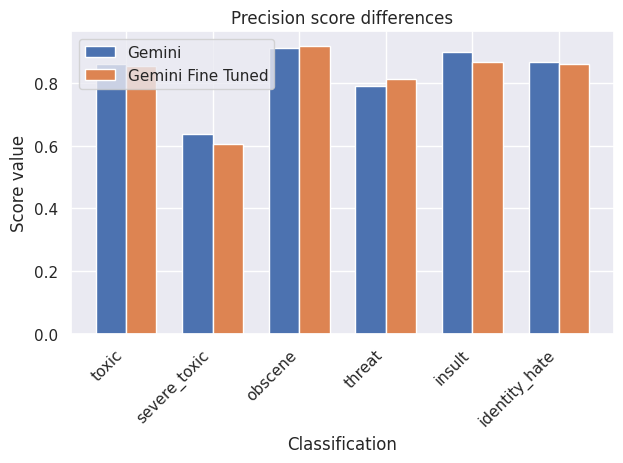

In [136]:
plot_differences("Precision score differences", precision_scores, precision_scores_tuned)

#### F1 Score

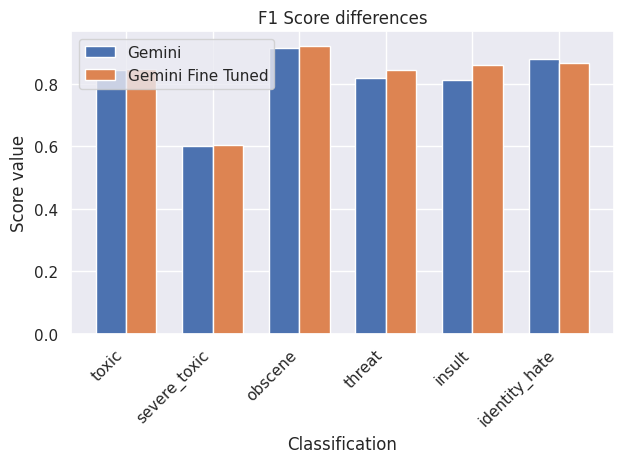

In [137]:
plot_differences("F1 Score differences", f1_scores, f1_scores_tuned)